In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import holidays

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [4]:
df = pd.read_csv('../data/sea_all_years.csv')

/Users/cf/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Drop unnamed column and NA
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)
df = df.dropna(axis=0, subset=['ArrTime', 'ArrDelay', 'DepDelay', 'DepTime', 'ActualElapsedTime', 'CRSElapsedTime', 'Distance'])

# Datetime processing
dates = df.ix[:, ['Year', 'Month', 'DayofMonth']]
dates.columns = ['year', 'month', 'day']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['Date'] = dates

# Select flights leaving Seattle
df_origin_sea = df.ix[df['Origin'] == 'SEA', :]

In [4]:
df_origin_sea.Date.describe()

count                 2744639
unique                  10470
top       2016-08-05 00:00:00
freq                      445
first     1988-01-01 00:00:00
last      2016-08-31 00:00:00
Name: Date, dtype: object

In [3]:
usholidays = holidays.UnitedStates()

In [19]:
# Monday holidays
mh = [n for n in df_origin_sea.Date.astype(datetime) if ((n in usholidays) & (n.isoweekday() == 1))]
mh = np.array(mh)
mh = np.unique(mh)

In [34]:
tsdt = df_origin_sea.Date[0]

In [35]:
tsdt.day

1

In [36]:
# Thanksgiving holidays
th = [n for n in df_origin_sea.Date.astype(datetime) if ((n in usholidays) & (n.day in range(22, 29)))]
th = np.array(th)
th = np.unique(th)

In [20]:
# Get Fridays before Monday holidays
fbmh = mh - timedelta(days=3)
fbmh = set(fbmh)
# Get day after Monday holidays
damh = mh + timedelta(days=1)
damh = set(damh)

In [37]:
# Get Friday after Thanksgiving and Wednesday, Tuesday before
fri_aft_thxgvng = th + timedelta(days=1)
wed_bef_thxgvng = th - timedelta(days=1)
tue_bef_thxgvng = th - timedelta(days=2)

In [43]:
cols = [fri_aft_thxgvng, wed_bef_thxgvng, tue_bef_thxgvng]
colnames = ['fri_after_thxgiving', 'wed_before_thxgiving', 'tue_before_thxgiving']

In [40]:
def filter_df_dates(dataframe, date_col_name, out_col_name, datelist):
    dts = set(datelist)
    dataframe[out_col_name] = [n in dts for n in dataframe[date_col_name].astype(datetime)] 
    return dataframe

In [45]:
for c, c_n in zip(cols, colnames):
    df_origin_sea = filter_df_dates(df_origin_sea, 'Date', c_n, c)

/Users/cf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [22]:
df_origin_sea['fri_before_holiday'] = [n in fbmh for n in df_origin_sea.Date.astype(datetime)]

/Users/cf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
df_origin_sea['tue_after__holiday'] = [n in damh for n in df_origin_sea.Date.astype(datetime)]

/Users/cf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
df_origin_sea.groupby('fri_before_holiday').mean()['DepDelay']

fri_before_holiday
False     7.492529
True     10.774924
Name: DepDelay, dtype: float64

In [28]:
df_origin_sea.groupby('tue_after__holiday').mean()['DepDelay']

tue_after__holiday
False    7.550920
True     7.395094
Name: DepDelay, dtype: float64

In [49]:
for c_n in colnames:
    print df_origin_sea.groupby(c_n).mean()['DepDelay']
for c_n in colnames:
    print df_after_2008.groupby(c_n).mean()['DepDelay']

fri_after_thxgiving
False    7.544545
True     8.077691
Name: DepDelay, dtype: float64
wed_before_thxgiving
False    7.534453
True     9.460951
Name: DepDelay, dtype: float64
tue_before_thxgiving
False     7.51468
True     12.09004
Name: DepDelay, dtype: float64
fri_after_thxgiving
False    5.705425
True     5.539833
Name: DepDelay, dtype: float64
wed_before_thxgiving
False    5.700968
True     6.158092
Name: DepDelay, dtype: float64
tue_before_thxgiving
False    5.679658
True     8.975602
Name: DepDelay, dtype: float64


In [46]:
df_after_2008 = df_origin_sea.ix[df_origin_sea['Date'] >= '2008-12-01', :]

In [47]:
df_after_2008.groupby('fri_before_holiday').mean()['DepDelay']

fri_before_holiday
False    5.684244
True     6.922603
Name: DepDelay, dtype: float64

In [50]:
(8.97 - 5.67)/5.67

0.5820105820105821

In [51]:
(6.92 - 5.68)/5.68

0.21830985915492962

In [53]:
# INCLUSIVE date selection tool
def select_by_dates(dataframe, start, end):
    return dataframe.ix[(dataframe['Date'] >= start) & (dataframe['Date'] <= end), :]

In [74]:
# Find n highest dates, using metric 'col'
def find_n_highest(dataframe, n, col):
    return dataframe.groupby('Date').mean()[col].sort_values(ascending=False)[:n]

In [230]:
def top_n_dates(r, df):
    bad_dates = []
    for i, n in enumerate(r):   
        bad_dates.append(find_n_highest(select_by_dates(df, str(n) + '-01-01', str(n) + '-12-31'), 20, 'LateAircraftDelay'))
        bad_dates[i].index = [dt.replace(year=2000) for dt in bad_dates[i].index]
    return bad_dates

In [231]:
def plot_years(span, df):
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.autofmt_xdate()
    bad_dates = top_n_dates(span, df)
    for n in bad_dates:
        ax.plot(n, '.', label=str(n))
    plt.show()

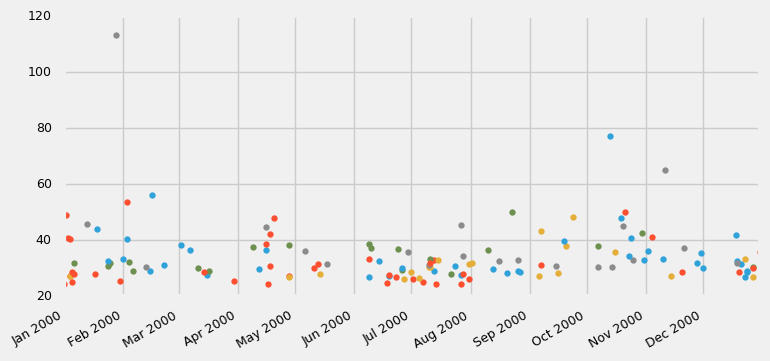

In [232]:
yr_rng = range(2008, 2015)
plot_years(yr_rng, df_origin_sea)

In [65]:
df_after_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824977 entries, 3916022 to 5578481
Data columns (total 35 columns):
ActualElapsedTime       824977 non-null float64
AirTime                 824977 non-null float64
ArrDelay                824977 non-null float64
ArrTime                 824977 non-null float64
CRSArrTime              824977 non-null float64
CRSDepTime              824977 non-null float64
CRSElapsedTime          824977 non-null float64
CancellationCode        0 non-null object
Cancelled               824977 non-null float64
CarrierDelay            124706 non-null float64
DayOfWeek               824977 non-null int64
DayofMonth              824977 non-null int64
DepDelay                824977 non-null float64
DepTime                 824977 non-null float64
Dest                    824977 non-null object
Distance                824977 non-null float64
Diverted                824977 non-null float64
FlightNum               824977 non-null int64
LateAircraftDelay       124706 